## Introduction

The purpose of this notebook is running K-Means clustering to see if the algorithm can sucessfully cluster the news in to 'Real' & 'Fake' using just the words in the articles

## Imports

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

## Data Analysis & Cleanup

In [24]:
import pandas as pd
import io
from google.colab import files

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
train = pd.read_csv('/content/gdrive/MyDrive/fake news detection(FakeNewsNet)/fnn_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/fake news detection(FakeNewsNet)/fnn_test.csv')

In [27]:
train = train.replace(to_replace ="fake",
                 value =1)
train = train.replace(to_replace ="real",
                 value =0)

In [28]:
test = test.replace(to_replace ="fake",
                 value =1)
test = test.replace(to_replace ="real",
                 value =0)

In [29]:
train = train.drop(['id','date', 'speaker', 'sources','paragraph_based_content'], axis=1)
test = test.drop(['id','date', 'speaker', 'sources','paragraph_based_content'], axis=1)


In [30]:
train.head(10)

statement  ... label_fnn
0  A national organization says Georgia has one o...  ...         1
1  Says Barack Obama's health care law "will be t...  ...         1
2  Says the Southwest Florida Water Management Di...  ...         1
3  "The Congressional Budget Office has this econ...  ...         0
4  Says the Treasury Department "says 41 percent ...  ...         1
5  "Seventy percent of all uninsured live in hous...  ...         0
6  The House health care bill provides for "free ...  ...         1
7    Says a pandemic occurs exactly every 100 years.  ...         1
8  Says the United States "actually exports more ...  ...         0
9  Says "he fought Obama at the Supreme Court — a...  ...         0

[10 rows x 3 columns]

In [31]:
train.fullText_based_content[7]

'According to this post on Facebook, pandemics like COVID-19 strike with eerie precision, every 100 years:\n"1720 — Plague; 1820 — Cholera outbreak; 1920 — Spanish flu; 2020 — Chinese coronavirus. What’s happening? There is a theory that every 100 years, a pandemic happens. At first glance, nothing seems strange, but the accuracy with which these events take place is scary."\nThe post was flagged as part of Facebook’s efforts to combat false news and misinformation on its News Feed. (Read more about our partnership with Facebook.)\nThe plague cited wasn’t a pandemic; two of the other examples didn’t occur neatly in the years cited; and, most importantly, numerous other pandemics have occurred without such synchronicity.\n"I am suspicious of the idea that pandemics operate to a railroad timetable," Yale University history professor Frank Snowden, author of "Epidemics and Society," told PolitiFact, noting several problems with the post.\nMany more than 4 pandemics\nThe World Health Organ

Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers

So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [32]:
# Merging title and text
train['fullText_based_content'] = train['statement'] + ' ' + train['fullText_based_content']
test['fullText_based_content'] = test['statement'] + ' ' + test['fullText_based_content']


# We can merge both together since we now have labels
final_data = pd.concat([train, test])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['statement'], axis = 1)
final_data = final_data.sample(frac=1)
final_data.head(10)

fullText_based_content  label_fnn
1918   "It costs nearly five times as much in Califor...          1
7649   Barack Obama "openly supported (opposition lea...          1
3938   "I’m ninth generation from New Hampshire." Sin...          0
14392  “Asteroid warning: NASA tracks a 4KM killer ro...          1
2540   "We spend less than 2 percent more every year....          0
6768   "On most things except witch trials, Virginia ...          1
4512   Says Jon Runyan voted to "end programs to aid ...          1
3751   "43,000 people are going to be kicked out of n...          1
10331  Says the state budget "doubled property tax cr...          0
2468   In every committee when the health care bill w...          0

In [33]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['fullText_based_content'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['label_fnn'])

## Word2Vec

In [34]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)

In [35]:
model.wv.most_similar("corona")

[('kills', 0.8372749090194702),
 ('bats', 0.8303860425949097),
 ('stomach', 0.8206810355186462),
 ('surfaces', 0.8192400932312012),
 ('spreading', 0.8128199577331543),
 ('novel', 0.8044428825378418),
 ('avian', 0.8027456402778625),
 ('sars', 0.8019458651542664),
 ('cov', 0.8012790083885193),
 ('infecting', 0.8006941080093384)]

## Sentence Vectors

In [36]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [37]:
X_np = np.array(X)
X_np.shape

(16266, 100)

## Clustering

In [38]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 118129.61983637372
start iteration
done sorting
end inner loop
Iteration 1, inertia 107365.96548250504
start iteration
done sorting
end inner loop
Iteration 2, inertia 105250.43477271267
start iteration
done sorting
end inner loop
Iteration 3, inertia 105002.30392786178
start iteration
done sorting
end inner loop
Iteration 4, inertia 104963.24626051889
start iteration
done sorting
end inner loop
Iteration 5, inertia 104949.43569209623
start iteration
done sorting
end inner loop
Iteration 6, inertia 104944.60060329617
start iteration
done sorting
end inner loop
Iteration 7, inertia 104943.24379084162
start iteration
done sorting
end inner loop
Iteration 8, inertia 104942.76963756369
start iteration
done sorting
end inner loop
Iteration 9, inertia 104942.57608555829
start iteration
done sorting
end inner loop
Iteration 10, inertia 104942.51701754589
center shift 2.971157e-06 within tolerance 7.678359

In [39]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

Sentence  Labels  Prediction
0  [costs, nearly, times, california, build, main...       1           0
1  [barack, obama, openly, supported, opposition,...       1           1
2  [i’m, ninth, generation, new, hampshire, lost,...       0           1
3  [“asteroid, warning, nasa, tracks, killer, roc...       1           1
4  [spend, percent, year, lowest, increase, spend...       0           0
5  [things, witch, trials, virginia, rep, morgan,...       1           1
6  [says, jon, runyan, voted, end, programs, aid,...       1           0
7  [people, going, kicked, nursing, homes, denied...       1           0
8  [says, state, budget, doubled, property, tax, ...       0           0
9  [committee, health, care, considered, democrat...       0           0

The results above show that its correctly clustered them in some cases where 0 is fake news and 1 is real news

In [40]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 58.57617115455552%


## Visualization

In [19]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [20]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

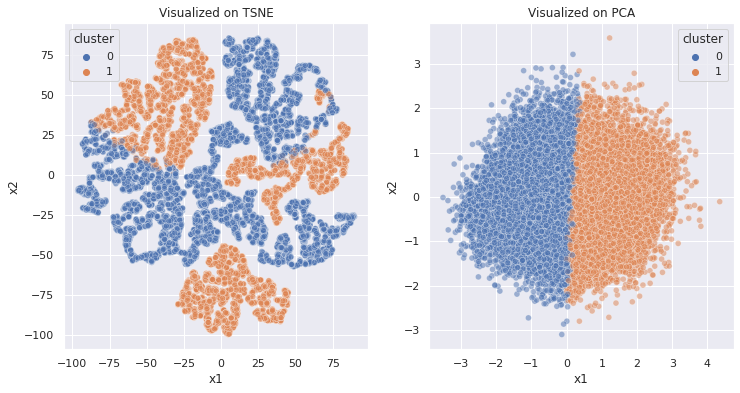

In [21]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [ ]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "On Thursday in the Afternoon, William Anderton , Printer , was brought to the Bar, and an Indictment of High-Treason was read against him; for that he did Compose, Print and publish Two Malicious, Scandalous and Traitorous Libels, The first Entitled, Remarks upon the present Confederacy, and late Revolution in England. The second Entitled, A French Conquest neither desirable, nor practicable."

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = Sentence_Vector(onion_data)

# Get prediction
kmeans.predict(np.array([onion_data]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([0], dtype=int32)

In [ ]:
# News from BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = Sentence_Vector(bbc_data)

# Get prediction
kmeans.predict(np.array([bbc_data]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1], dtype=int32)